# 1. Импортирование библиотек и модулей

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from IPython.display import HTML
import matplotlib.pyplot as plt

# 2.Загрузка обучающей и тестовой выборок

In [2]:
fname_tr = "HDAC1/Sets/HDAC1 work set_st.sdf"

mols_tr = []
y_tr = []
for mol in Chem.SDMolSupplier(fname_tr):
    if mol is not None:
        mols_tr.append(mol)
        y_tr.append(mol.GetIntProp("HDAC1"))

In [3]:
fname_ts = "HDAC1/Sets/HDAC1  test  set_st.sdf"

mols_ts = []
y_ts = []
for mol in Chem.SDMolSupplier(fname_ts):
    if mol is not None:
        mols_ts.append(mol)
        y_ts.append(mol.GetIntProp("HDAC1"))

# 3.Расчет дескрипторов обучающей выборки

In [4]:
fp_tr = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2,nBits=1024,useFeatures=False,useChirality = False) for m in mols_tr]

In [5]:
def rdkit_numpy_convert(fp_tr):
    output = []
    for f in fp_tr:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [6]:
from numpy import savetxt
x_tr = rdkit_numpy_convert(fp_tr)

In [7]:
savetxt('HDAC1/Models/FP/x_tr.csv', x_tr, delimiter=',')

In [8]:
x_tr.shape

(169, 1024)

# 4. Расчет дескрипторов тестовой выборки

In [9]:
fp_ts = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2,nBits=1024,useFeatures=False,useChirality = False) for m in mols_ts]

In [10]:
def rdkit_numpy_convert(fp_ts):
    output = []
    for f in fp_ts:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [11]:
x_ts = rdkit_numpy_convert(fp_ts)

In [12]:
x_ts.shape

(42, 1024)

# 5. Построение и валидация модели RF 

## 5.1. Построение модели RF 

In [13]:
seed = 42

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [15]:
param_grid = {"max_features": [x_tr.shape[1] // 10, x_tr.shape[1] // 7, x_tr.shape[1] // 5, x_tr.shape[1] // 3],
              "n_estimators": [100, 250, 500, 1000]}

In [16]:
m = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [17]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [102, 146, 204, 341],
                         'n_estimators': [100, 250, 500, 1000]},
             verbose=1)

In [18]:
m.best_params_

{'max_features': 146, 'n_estimators': 500}

In [19]:
best_clf_RF = m.best_estimator_

## 5.2. 5-fold-cross-validation  модели RF

In [20]:
y_pred_CV_RF = cross_val_predict(best_clf_RF, x_tr, y_tr, cv=cv)

In [21]:
confusion_matrix_RF = metrics.confusion_matrix(y_tr, y_pred_CV_RF, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_tr, y_pred_CV_RF, weights='linear')
TN, FP, FN, TP = confusion_matrix_RF.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.88
SE =  0.83
SP =  0.93
Kappa =  0.77


In [22]:
pickle.dump(best_clf_RF, open('HDAC1/Models/FP/HDAC1_RF_ECFP4.pkl', 'wb'))

## 5.3.Y-randomization для модели RF

In [23]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(best_clf_RF, x_tr, y_tr,
                                                           cv=cv, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min finished


True score =  0.88 
Y-randomization =  0.49 
p-value =  0.0476


## 5.4. Валидация на внешней тестовой выборке для модели RF

In [24]:
y_pred_rf = best_clf_RF.predict(x_ts)

In [25]:
y_pred_rf

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [26]:
confusion_matrix_ts = metrics.confusion_matrix(y_ts, y_pred_rf, labels=[0,1])

In [27]:
Kappa = metrics.cohen_kappa_score(y_ts, y_pred_rf, weights='linear')
TN, FP, FN, TP = confusion_matrix_ts.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.76
SE =  0.76
SP =  0.76
Kappa =  0.52


## 5.5. Выявление 5 наиболее значимых признаков

# 6. Расчет AD методом Euclidian distances при K=1 (https://doi.org/10.1021/acs.jcim.0c00415)

In [28]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [29]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.898979,4.898979,3.000000,3.162278,2.828427,4.690416,2.828427,8.544004,0.000000,2.828427,...,3.605551,5.830952,4.472136,6.082763,5.830952,5.291503,3.316625,2.828427,5.291503,7.483315
2,7.483315,6.557439,3.316625,3.464102,3.162278,5.196152,3.162278,8.660254,4.242641,3.162278,...,3.872983,9.000000,4.472136,6.324555,8.774964,5.385165,4.123106,3.316625,5.477226,7.483315
3,7.483315,6.855655,3.316625,3.741657,3.162278,5.385165,3.162278,8.888194,5.196152,3.162278,...,4.358899,9.000000,4.582576,6.403124,8.774964,6.000000,5.196152,4.000000,5.567764,7.874008
4,7.681146,6.928203,3.316625,4.000000,3.162278,5.567764,3.316625,8.888194,5.196152,3.316625,...,5.000000,9.165151,5.385165,6.403124,8.774964,6.082763,6.000000,5.567764,5.567764,7.874008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,10.392305,9.643651,10.148892,10.392305,10.198039,9.327379,10.198039,10.862780,10.049876,10.295630,...,10.583005,11.045361,9.486833,9.591663,10.583005,9.055385,10.344080,10.148892,9.055385,10.148892
165,10.392305,9.643651,10.246951,10.392305,10.295630,9.380832,10.198039,10.908712,10.099505,10.295630,...,10.583005,11.045361,9.539392,9.643651,10.630146,9.110434,10.344080,10.148892,9.055385,10.148892
166,10.440307,9.848858,10.344080,10.392305,10.295630,9.486833,10.295630,10.954451,10.148892,10.392305,...,10.583005,11.045361,9.539392,9.695360,10.677078,9.219544,10.392305,10.246951,9.165151,10.295630
167,10.440307,9.949874,10.583005,10.630146,10.440307,9.643651,10.535654,11.000000,10.440307,10.535654,...,10.908712,11.090537,9.539392,9.797959,10.723805,9.486833,10.392305,10.392305,9.219544,10.295630


In [30]:
similarity= neighbors_k

In [31]:
Dmean=np.mean(similarity[1,:])

In [32]:
round(Dmean, 2)

3.32

In [33]:
std=np.std(similarity[1,:])

In [34]:
round(std, 2)

1.57

In [35]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

4.11


In [36]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [37]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,3.741657,0.000000,6.403124,3.872983,3.162278,4.795832,0.000000,3.162278,3.741657,3.000000,...,3.872983,5.000000,6.708204,3.162278,3.316625,1.000000,2.645751,2.828427,2.645751,5.385165
1,3.741657,3.162278,6.557439,4.242641,3.316625,5.099020,1.000000,4.000000,4.358899,3.000000,...,4.582576,7.141428,7.141428,3.316625,4.795832,4.898979,3.872983,4.123106,3.872983,5.916080
2,3.741657,3.316625,6.633250,4.242641,3.464102,5.099020,1.732051,4.123106,4.358899,3.162278,...,4.582576,7.483315,7.615773,4.690416,5.656854,4.898979,4.242641,4.795832,4.898979,6.244998
3,3.872983,3.464102,6.708204,4.242641,3.605551,5.099020,2.828427,4.358899,4.358899,3.605551,...,4.795832,7.483315,7.681146,5.385165,6.324555,5.291503,4.582576,5.567764,5.385165,6.324555
4,4.000000,3.464102,6.782330,4.242641,3.741657,5.099020,3.000000,4.795832,4.690416,3.741657,...,4.795832,7.483315,7.874008,5.656854,6.633250,6.164414,6.000000,6.480741,6.633250,6.480741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,10.198039,9.110434,9.746794,10.392305,10.295630,10.488088,9.591663,9.591663,9.949874,9.380832,...,9.380832,10.295630,10.344080,9.486833,10.148892,10.392305,10.148892,10.344080,10.295630,9.327379
165,10.295630,9.165151,9.746794,10.488088,10.392305,10.677078,9.591663,9.591663,9.949874,9.380832,...,9.380832,10.344080,10.392305,9.643651,10.148892,10.488088,10.198039,10.344080,10.392305,9.486833
166,10.295630,9.273618,9.746794,10.488088,10.488088,10.770330,9.643651,9.643651,10.049876,9.380832,...,9.486833,10.344080,10.440307,9.695360,10.246951,10.535654,10.198039,10.392305,10.488088,9.539392
167,10.535654,9.327379,9.848858,10.723805,10.630146,11.000000,9.695360,9.797959,10.049876,9.486833,...,9.486833,10.344080,10.488088,9.797959,10.440307,10.535654,10.344080,10.392305,10.630146,9.643651


In [38]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[3.742 0.    6.403 3.873 3.162 4.796 0.    3.162 3.742 3.    0.    3.317
 0.    0.    4.583 0.    3.    3.317 0.    1.    0.    4.123 3.162 3.873
 4.796 4.899 3.    3.317 1.732 1.    0.    1.    3.873 5.    6.708 3.162
 3.317 1.    2.646 2.828 2.646 5.385]


In [39]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False  True  True False  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False False  True
  True  True  True  True  True False]


In [40]:
print("Coverage = ", sum(cpd_AD) / len(cpd_AD))

Coverage =  0.7857142857142857


In [41]:
print("Индексы соединений, вошедших в AD = ", np.where(cpd_AD != 0)[0])

Индексы соединений, вошедших в AD =  [ 0  1  3  4  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 26 27 28 29
 30 31 32 35 36 37 38 39 40]


# Расчет области применимости методом bounding box

In [42]:
maxInColumns = np.amax(x_tr, axis=0)
minInColumns = np.amin(x_tr, axis=0)
print('Max value of every column: ', maxInColumns)
print('Min value of every column: ', minInColumns)
df_tr = pd.DataFrame.from_dict({'max': maxInColumns,'min':minInColumns})
df_tr

Max value of every column:  [1. 1. 0. ... 0. 1. 0.]
Min value of every column:  [0. 0. 0. ... 0. 0. 0.]


,max,min
0,1.0,0.0
1,1.0,0.0
2,0.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
1019,1.0,0.0
1020,0.0,0.0
1021,0.0,0.0
1022,1.0,0.0


In [43]:
maxInColumns_ts = np.amax(x_ts, axis=0)
minInColumns_ts = np.amin(x_ts, axis=0)
print('Max value of every column: ', maxInColumns_ts)
print('Min value of every column: ', minInColumns_ts)
df_ts = pd.DataFrame.from_dict({'max': maxInColumns_ts,'min':minInColumns_ts})
df_ts

Max value of every column:  [1. 1. 1. ... 0. 0. 0.]
Min value of every column:  [0. 0. 0. ... 0. 0. 0.]


,max,min
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
1019,1.0,0.0
1020,0.0,0.0
1021,0.0,0.0
1022,0.0,0.0


In [44]:
a = np.greater_equal(maxInColumns, x_ts)
b = np.less_equal(minInColumns, x_ts)
c = np.logical_and(a, b)
d = np.all(c, axis=1)
print(d)
print(np.where(d != 0)[0])
print("Coverage = ", sum(d) / len(d))

[ True  True False False False  True  True  True False False  True  True
  True  True  True  True False False  True  True  True False  True  True
 False  True  True  True  True  True  True  True False False False  True
  True  True False False False  True]
[ 0  1  5  6  7 10 11 12 13 14 15 18 19 20 22 23 25 26 27 28 29 30 31 35
 36 37 41]
Coverage =  0.6428571428571429


# Расчет области применимости методом оценки вероятностей прогноза

In [45]:
pred_prob = best_clf_RF.predict_proba(x_ts)

In [46]:
pred_prob

array([[0.033     , 0.967     ],
       [0.00933333, 0.99066667],
       [0.724     , 0.276     ],
       [0.046     , 0.954     ],
       [0.018     , 0.982     ],
       [0.12      , 0.88      ],
       [0.188     , 0.812     ],
       [0.272     , 0.728     ],
       [0.608     , 0.392     ],
       [0.112     , 0.888     ],
       [0.09433333, 0.90566667],
       [0.034     , 0.966     ],
       [0.14563333, 0.85436667],
       [0.103     , 0.897     ],
       [0.906     , 0.094     ],
       [0.95      , 0.05      ],
       [0.03      , 0.97      ],
       [0.14      , 0.86      ],
       [0.18566667, 0.81433333],
       [0.25933333, 0.74066667],
       [0.861     , 0.139     ],
       [0.018     , 0.982     ],
       [0.984     , 0.016     ],
       [0.97      , 0.03      ],
       [0.956     , 0.044     ],
       [0.91      , 0.09      ],
       [0.944     , 0.056     ],
       [0.93      , 0.07      ],
       [0.996     , 0.004     ],
       [0.95066667, 0.04933333],
       [0.

In [47]:
threshold = 0.7

In [48]:
da = np.amax(pred_prob, axis=1) > threshold
da

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True])

In [49]:
print("Coverage = ", sum(da) / len(da))

Coverage =  0.9523809523809523


# Tanimoto score with ECFP4

In [50]:
d_ECFP4 = {}
for mol in Chem.SDMolSupplier("HDAC1/Sets/HDAC1 work set_st.sdf"):
    mg = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2,nBits=1024,useFeatures=False,useChirality = False)
    for m in Chem.SDMolSupplier('HDAC1/Sets/HDAC1  test  set_st.sdf'):
        if m is not None:
            mg_ = AllChem.GetMorganFingerprintAsBitVect(m, radius=2,nBits=1024,useFeatures=False,useChirality = False)
            d_ECFP4.setdefault(Chem.MolToSmiles(m),[]).append(DataStructs.FingerprintSimilarity(mg, mg_))

In [51]:
df_ECFP4 = pd.DataFrame.from_dict(d_ECFP4)

In [52]:
df_ECFP4.max()

CN(Cc1nc2c(N3CCOCC3)nc(-c3cccc(O)c3)nc2n1C)c1ncc(C(=O)NO)cn1                            0.808219
O=C(CCCCCCC(=O)NN=Cc1ccc(-c2ccccc2)cc1)NO                                               1.000000
Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1                                               0.405797
COc1cc(-c2nc(N3CCOCC3)c3nc(CN(C)c4ncc(C(=O)NO)cn4)n(C)c3n2)cc(OC)c1OC                   0.797297
CN(Cc1nc2c(N3CCOCC3)nc(-c3ccc(N)nc3)nc2n1C)c1ncc(C(=O)NO)cn1                            0.857143
COc1ccc(C(F)(F)F)cc1-c1nc(N2CCOCC2)c2nc(CN(C)c3ncc(C(=O)NO)cn3)n(C)c2n1                 0.716049
COc1cccc(-c2ccc3c(NC(=O)CCCCCCC(=O)NO)[nH]nc3c2)c1                                      1.000000
COc1cccc(-c2ccc3c(NC(=O)CCCCCCC(=O)NO)[nH]nc3n2)c1                                      0.818182
CCN(CC)Cc1ccc2cc(CN3CCN(c4ccc(C(=O)NO)cc4)C3=O)ccc2c1                                   0.745455
O=C(CCCCCCC(=O)Nc1[nH]nc2cc(-c3ccc(Cl)cc3)ccc12)NO                                      0.820000
O=C(CCCCCCn1cc(-c2ccc(Nc3c4ccc

In [53]:
threshold = 0.6
da_ECFP4 = np.asarray(df_ECFP4)
da_ECFP4 = np.amax(df_ECFP4, axis=0) >= threshold
da_ECFP4

CN(Cc1nc2c(N3CCOCC3)nc(-c3cccc(O)c3)nc2n1C)c1ncc(C(=O)NO)cn1                             True
O=C(CCCCCCC(=O)NN=Cc1ccc(-c2ccccc2)cc1)NO                                                True
Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1                                               False
COc1cc(-c2nc(N3CCOCC3)c3nc(CN(C)c4ncc(C(=O)NO)cn4)n(C)c3n2)cc(OC)c1OC                    True
CN(Cc1nc2c(N3CCOCC3)nc(-c3ccc(N)nc3)nc2n1C)c1ncc(C(=O)NO)cn1                             True
COc1ccc(C(F)(F)F)cc1-c1nc(N2CCOCC2)c2nc(CN(C)c3ncc(C(=O)NO)cn3)n(C)c2n1                  True
COc1cccc(-c2ccc3c(NC(=O)CCCCCCC(=O)NO)[nH]nc3c2)c1                                       True
COc1cccc(-c2ccc3c(NC(=O)CCCCCCC(=O)NO)[nH]nc3n2)c1                                       True
CCN(CC)Cc1ccc2cc(CN3CCN(c4ccc(C(=O)NO)cc4)C3=O)ccc2c1                                    True
O=C(CCCCCCC(=O)Nc1[nH]nc2cc(-c3ccc(Cl)cc3)ccc12)NO                                       True
O=C(CCCCCCn1cc(-c2ccc(Nc3c4ccccc4nc4ccccc34)cc2)nn1)NO      

In [54]:
print("Coverage = ", sum(da_ECFP4) / len(da_ECFP4))

Coverage =  0.9047619047619048


# 7. Построение и валидация модели GBM

## 7.1. Построение модели GBM

In [55]:
param_grid = {"n_estimators": [100, 200, 300, 400, 500]}
gbm = GridSearchCV(GradientBoostingClassifier(subsample=0.5, max_features=0.5), 
                   param_grid, n_jobs=2, cv=cv, verbose=1)

In [56]:
gbm.fit(x_tr, y_tr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_features=0.5,
                                                  subsample=0.5),
             n_jobs=2, param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

In [57]:
gbm.best_params_

{'n_estimators': 100}

In [58]:
best_clf_GBM = gbm.best_estimator_

## 7.2.  5-fold-cross-validation  модели GBM

In [59]:
y_pred_CV_GBM = cross_val_predict(best_clf_GBM, x_tr, y_tr, cv=cv)

In [60]:
confusion_matrix_CV_GBM = metrics.confusion_matrix(y_tr, y_pred_CV_GBM, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_tr, y_pred_CV_GBM, weights='linear')
TN, FP, FN, TP = confusion_matrix_CV_GBM.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.87
SE =  0.81
SP =  0.93
Kappa =  0.75


In [61]:
pickle.dump(best_clf_RF, open('HDAC1/Models/FP/HDAC1_GBM_ECFP4.pkl', 'wb'))

## 7.3.Y-randomization для модели GBM

In [62]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(best_clf_GBM, x_tr, y_tr,
                                                           cv=cv, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.8s finished


True score =  0.87 
Y-randomization =  0.5 
p-value =  0.0476


## 7.4. Валидация на тестовой выборке для модели GBM

In [63]:
y_pred_gbm = best_clf_GBM.predict(x_ts)

In [64]:
y_pred_gbm

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [65]:
confusion_matrix_GBM = metrics.confusion_matrix(y_ts, y_pred_gbm, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_ts, y_pred_gbm, weights='linear')
TN, FP, FN, TP = confusion_matrix_GBM.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.81
SE =  0.82
SP =  0.8
Kappa =  0.61


# 8. Построение и валидация модели SVM

## 8.1. Построение модели SVM

In [66]:
scale = StandardScaler().fit(x_tr)
x_tr_sc = scale.transform(x_tr)

In [67]:
joblib.dump(scale, "HDAC1/Models/FP/HDAC1_ws_for SVM.pkl", compress=3)

['HDAC1/Models/FP/HDAC1_ws_for SVM.pkl']

In [68]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [69]:
svm = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, n_jobs=2, cv=cv, verbose=1)

In [70]:
svm.fit(x_tr_sc, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True), n_jobs=2,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [71]:
best_clf_SVM = svm.best_estimator_

## 8.2. 5-fold-cross-validation модели SVM

In [72]:
y_pred_CV_SVM = cross_val_predict(best_clf_SVM, x_tr_sc, y_tr, cv=cv)

In [73]:
confusion_matrix_CV_SVM = metrics.confusion_matrix(y_tr, y_pred_CV_SVM, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_tr, y_pred_CV_SVM, weights='linear')
TN, FP, FN, TP = confusion_matrix_CV_SVM.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.86
SE =  0.83
SP =  0.89
Kappa =  0.72


In [74]:
pickle.dump(best_clf_RF, open('HDAC1/Models/FP/HDAC1_SVM_ECFP4.pkl', 'wb'))

## 8.3.Y-randomization для модели SVM

In [75]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(best_clf_SVM, x_tr_sc, y_tr,
                                                           cv=cv, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


True score =  0.86 
Y-randomization =  0.49 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.5s finished


## 8.4. Валидация на тестовой выборке для модели SVM

In [76]:
scale = joblib.load("HDAC1/Models/FP/HDAC1_ws_for SVM.pkl")
x_ts_sc = scale.transform(x_ts)

In [77]:
y_pred_SVM = best_clf_SVM.predict(x_ts_sc)

In [78]:
y_pred_SVM

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [79]:
confusion_matrix_SVM = metrics.confusion_matrix(y_ts, y_pred_SVM, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_ts, y_pred_SVM, weights='linear')
TN, FP, FN, TP = confusion_matrix_SVM.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.81
SE =  0.82
SP =  0.8
Kappa =  0.61


# 9. Консенсусное моделирование

## 9.1.  5-fold CV

In [80]:
y_pred_cv_con = 1 * (((y_pred_CV_RF + y_pred_CV_GBM + y_pred_CV_SVM) / 3) >= 0.5)

In [81]:
confusion_matrix_cv_con = metrics.confusion_matrix(y_tr, y_pred_cv_con, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_tr, y_pred_cv_con, weights='linear')
TN, FP, FN, TP = confusion_matrix_cv_con.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.87
SE =  0.81
SP =  0.92
Kappa =  0.74


## 9.2. Test set

In [82]:
pred_c = 1 * (((y_pred_rf + y_pred_gbm + y_pred_SVM) / 3) >= 0.5)

In [83]:
pred_c

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [84]:
confusion_matrix_GBM = metrics.confusion_matrix(y_ts, pred_c, labels=[0,1])
Kappa = metrics.cohen_kappa_score(y_ts, pred_c, weights='linear')
TN, FP, FN, TP = confusion_matrix_GBM.ravel()
SE = TP/(TP+FN)
SP = TN/(TN+FP)
BA = (SE + SP)/2
print("balanced_accuracy = ", round((BA), 2))
print("SE = ", round((SE), 2))
print("SP = ", round((SP), 2))
print("Kappa = ", round((Kappa), 2))

balanced_accuracy =  0.78
SE =  0.76
SP =  0.8
Kappa =  0.56


# 10.Make predictions

In [86]:
# Set file path and format
file = 'HDAC1/Sets/example.sdf'
mol_input = 1

# Read SDF
if mol_input == 1:
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)
    # Rename ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')
    # Columns
    print('Kept data: ', moldf.shape)

    
# Read txt or CSV 
elif mol_input == 2:
    moldf = pd.read_csv(file, sep='\t', encoding='utf-8')
    # Add Mol column
    PandasTools.AddMoleculeColumnToFrame(moldf, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    # Columns
    print(moldf.shape)

from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

Original data:  (5, 4)
Kept data:  (5, 4)

 Problematic structures: 
 []


,InChIKey,SMILES,ID,Mol
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,
1,NGMGFRRMBXLNNS-UHFFFAOYSA-N,Cc1ccc(CSc2nc3ccncc3n2CC(=O)Nc2cc(C)cc(C)c2)cc1,,

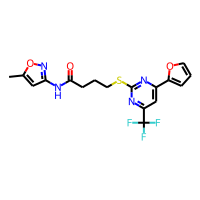
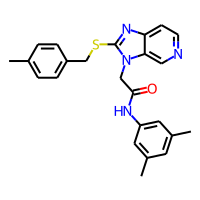

In [90]:
HTML(moldf.head(2).to_html())

In [91]:
def calcfp(mol,funcFPInfo=dict(radius=2,nBits=1024,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

moldf['Descriptors'] = moldf.Mol.apply(calcfp)
x_vs = np.array(list(moldf['Descriptors'])).astype(int)
x_vs.shape


(5, 1024)

In [92]:
y_pred_rf_vs = best_clf_RF.predict(x_vs)
y_pred_gbm_vs = best_clf_GBM.predict(x_vs)
x_vs_s = scale.transform(x_vs)
y_pred_SVM_vs = best_clf_SVM.predict(x_vs_s)
pred_c = 1 * (((y_pred_rf_vs + y_pred_gbm_vs + y_pred_SVM_vs) / 3) >= 0.5)
print("Прогнозируемые классы активностей HDAC1 = ", pred_c)

Прогнозируемые классы активностей HDAC1 =  [0 0 0 0 0]


estimination AD

In [93]:
neighbors_k_vs= pairwise_distances(x_tr,Y=x_vs, n_jobs=-1)
neighbors_k_vs.sort(0)

In [94]:
x_vs_AD=pd.DataFrame(neighbors_k_vs)
x_vs_AD

,0,1,2,3,4
0,7.280110,7.416198,7.549834,8.185353,7.874008
1,7.416198,7.549834,7.615773,8.246211,7.937254
2,7.810250,7.615773,7.681146,8.366600,8.000000
3,7.874008,7.745967,7.937254,8.426150,8.000000
4,7.874008,7.874008,8.000000,8.485281,8.062258
...,...,...,...,...,...
164,10.000000,9.797959,10.000000,10.148892,10.148892
165,10.099505,9.797959,10.000000,10.198039,10.198039
166,10.148892,10.000000,10.198039,10.295630,10.198039
167,10.148892,10.049876,10.246951,10.344080,10.246951


In [95]:
similarity_vs= neighbors_k_vs
cpd_AD_vs=similarity_vs[0,:]
cpd_value_vs = np.round(cpd_AD_vs, 3)
print(cpd_value_vs)

[7.28  7.416 7.55  8.185 7.874]


In [96]:
cpd_AD_vs = np.where(cpd_value_vs <= model_AD_limit, True, False)
print(cpd_AD_vs)

[False False False False False]


In [97]:
print("Coverage = ", sum(cpd_AD_vs) / len(cpd_AD_vs))

Coverage =  0.0


In [98]:
print("Индексы соединений, вошедших в AD = ", np.where(cpd_AD_vs != 0)[0])

Индексы соединений, вошедших в AD =  []


Export predictions

In [99]:
pred_beta = pd.DataFrame({'HDAC1': pred_c,'HDAC1_AD': cpd_AD_vs}, index=None)

In [100]:
predictions = pd.concat([moldf, pred_beta], axis=1)
predictions.drop(columns='Descriptors', inplace=True)
predictions.head()

,InChIKey,SMILES,ID,Mol,HDAC1,HDAC1_AD
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,"<img data-content=""rdkit/molecule"" src=""data:i...",0,False
1,NGMGFRRMBXLNNS-UHFFFAOYSA-N,Cc1ccc(CSc2nc3ccncc3n2CC(=O)Nc2cc(C)cc(C)c2)cc1,,"<img data-content=""rdkit/molecule"" src=""data:i...",0,False
2,NWUXAQZDESOKKL-MFKUBSTISA-N,COc1ccc(Br)cc1/C=N/NC(=O)c1nc(-c2ccccc2)n2c1CC...,,"<img data-content=""rdkit/molecule"" src=""data:i...",0,False
3,NIJNUARVFJGCOA-UHFFFAOYNA-N,C=CCOc1cccc(C2c3c(oc4ccccc4c3=O)C(=O)N2c2ccccn...,,"<img data-content=""rdkit/molecule"" src=""data:i...",0,False
4,FOYOYADXADLUCK-UHFFFAOYNA-N,O=C1OCCN1C(=O)C1C(c2ccccc2)C(c2cccc(Cl)c2)=NN1...,,"<img data-content=""rdkit/molecule"" src=""data:i...",0,False


,InChIKey,SMILES,ID,Mol,HDAC1,HDAC1_AD
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,,0,False
1,NGMGFRRMBXLNNS-UHFFFAOYSA-N,Cc1ccc(CSc2nc3ccncc3n2CC(=O)Nc2cc(C)cc(C)c2)cc1,,,0,False
2,NWUXAQZDESOKKL-MFKUBSTISA-N,COc1ccc(Br)cc1/C=N/NC(=O)c1nc(-c2ccccc2)n2c1CCCCC2,,,0,False
3,NIJNUARVFJGCOA-UHFFFAOYNA-N,C=CCOc1cccc(C2c3c(oc4ccccc4c3=O)C(=O)N2c2ccccn2)c1,,,0,False
4,FOYOYADXADLUCK-UHFFFAOYNA-N,O=C1OCCN1C(=O)C1C(c2ccccc2)C(c2cccc(Cl)c2)=NN1c1ccc(Br)cc1,,,0,False

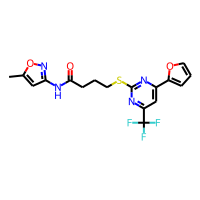
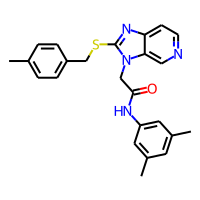
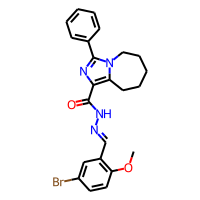
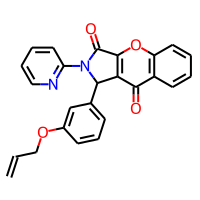
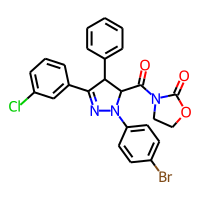

In [101]:
HTML(predictions.to_html())

# Generate maps of fragment contribution

In [102]:
from rdkit.Chem.Draw import SimilarityMaps
from matplotlib import cm



def pred_frag(mol, model, radius=2, nBits=1024):

    def getProba(fp, probabilityfunc):
        return probabilityfunc(fp)[0][1]

    def fpFunction(mol,atomId=-1):
        fp = SimilarityMaps.GetMorganFingerprint(mol,
                                                 atomId=atomId,
                                                 radius=radius,
                                                 nBits=nBits)
        return fp

    fig = SimilarityMaps.GetSimilarityMapForModel(mol,
                                                  fpFunction,
                                                  lambda x: getProba((x,),
                                                  model.predict_proba),
                                                  colorMap=cm.PiYG_r)

Generating maps with predicted fragment contribution for beta-lactamase...


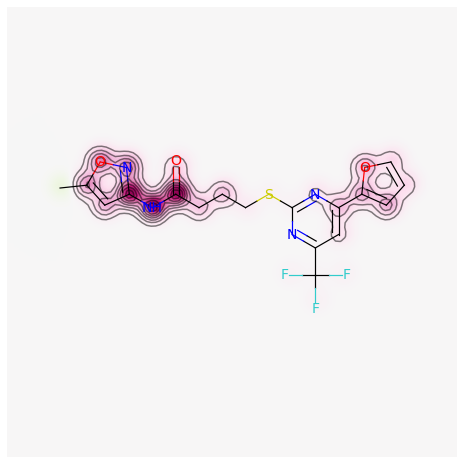

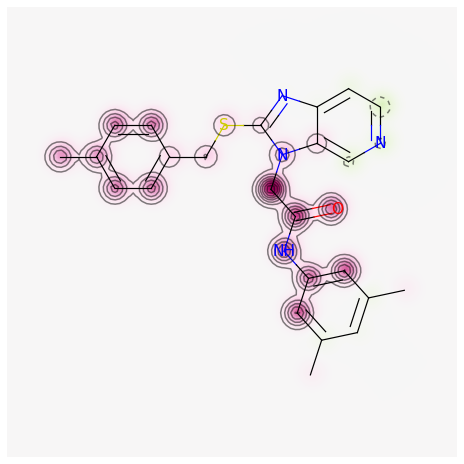

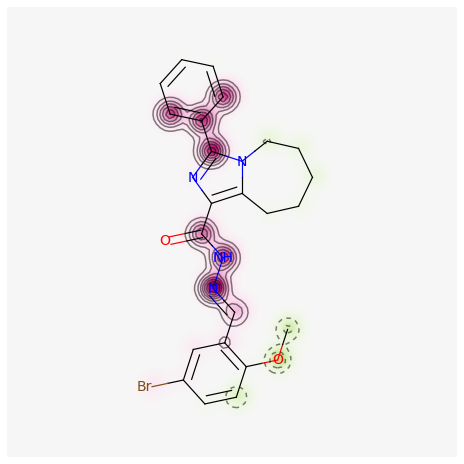

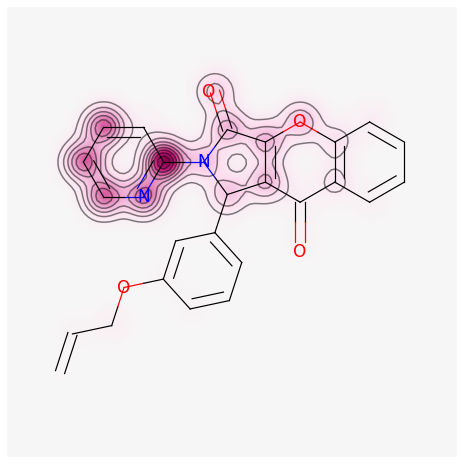

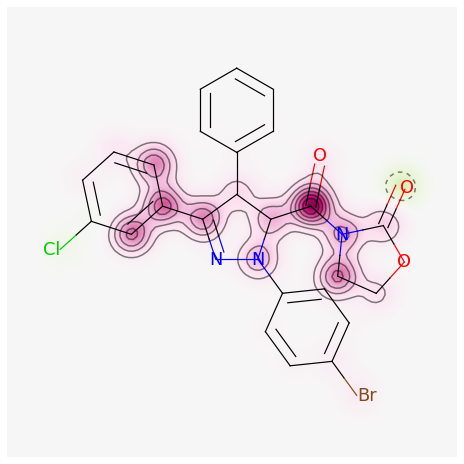

In [104]:
print('Generating maps with predicted fragment contribution for beta-lactamase...')
for i, mol in zip(range(len(moldf.Mol)), moldf.Mol):
    pred_frag(mol, best_clf_RF)
    plt.savefig('maps/mol_' + str(i+1) + '_beta-lactamase.png', bbox_inches='tight')